# CSE 256 Project
## baseline model
### Specific: CNN model or LSTM model

In [ ]:
!pip install -U torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [ ]:
# module import

import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

## Standford Stentiment Treebank Data Preparing and Data Processing

In [ ]:
# import libraries that will help us preprocess data, map to word embeddings
import torchtext
from torchtext.vocab import Vectors, GloVe

In [ ]:
print(torch.__version__)

2.0.1+cu118


In [ ]:
print(torchtext.__version__)

0.6.0


## Convolutional Neural Network Model

In [ ]:
# this will be our input x to the classifiers
text_cnn = torchtext.data.Field()

# this will be what we map to, the tag y
label_cnn = torchtext.data.Field(sequential=False)

In [ ]:
# split the dataset into train, val, and test sets. Exclude neutral labels, so just positive or negative
train_cnn, val_cnn, test_cnn = torchtext.datasets.SST.splits(text_cnn, label_cnn, filter_pred=lambda ex: ex.label != 'neutral')

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:00<00:00, 1.40MB/s]


extracting


In [ ]:
# each consists of a label and it's original words
print('len(train)', len(train_cnn))
print('vars(train[0])', vars(train_cnn[0]))

len(train) 6920
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}


In [ ]:
# assign an index to each word and label (unique) kind of like countvectorizer
text_cnn.build_vocab(train_cnn)
label_cnn.build_vocab(train_cnn)
print('len(text_cnn.vocab)', len(text_cnn.vocab))
print('len(label_cnn.vocab)', len(label_cnn.vocab))

len(text_cnn.vocab) 16284
len(label_cnn.vocab) 3


In [ ]:
# produce three batch iterators that iterate 10 examples at a time
train_cnn_iter, val_cnn_iter, test_cnn_iter = torchtext.data.BucketIterator.splits((train_cnn, val_cnn, test_cnn), batch_size=10, device=-1)

In [ ]:
# Build the vocabulary with word embeddings
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
text_cnn.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

print("Word embeddings size ", text_cnn.vocab.vectors.size())
print("Word embedding of 'follows', first 10 dim ", text_cnn.vocab.vectors[text_cnn.vocab.stoi['follows']][:10])

.vector_cache/wiki.simple.vec: 293MB [00:08, 33.8MB/s]                           
100%|██████████| 111051/111051 [00:14<00:00, 7627.24it/s]


Word embeddings size  torch.Size([16284, 300])
Word embedding of 'follows', first 10 dim  tensor([ 0.3925, -0.4770,  0.1754, -0.0845,  0.1396,  0.3722, -0.0878, -0.2398,
         0.0367,  0.2800])


In [ ]:
batch_cnn = next(iter(train_cnn_iter))

In [ ]:
print("Size of text batch [max sent length, batch size]", batch_cnn.text.size())
print("Second in batch", batch_cnn.text[:, 0])
print("Converted back to string: ", " ".join([text_cnn.vocab.itos[i] for i in batch_cnn.text[:, 0].data]))

Size of text batch [max sent length, batch size] torch.Size([46, 10])
Second in batch tensor([ 1156,   398,   212,   149,    56,     6,     4, 12186,     3,  1190,
         1327,   106,    56,     3,    19,  7509,    12,     4,   868,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1])
Converted back to string:  Rock solid family fun out of the gates , extremely imaginative through out , but wanes in the middle <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size):
        super(CNN, self).__init__()
        self.embeddings = nn.Embedding(text_cnn.vocab.vectors.size()[0], text_cnn.vocab.vectors.size()[1])
        self.embeddings.weight.data.copy_(text_cnn.vocab.vectors)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = in_channels, out_channels = in_channels, kernel_size = n) for n in (2,3,4)])
        self.dropout_train, self.dropout_test = nn.Dropout(p = 0.5), nn.Dropout(p = 0)
        self.linear = nn.Linear(in_features=in_channels, out_features=out_channels, bias = True)

    def forward(self, x, train = True):
        embedded = self.embeddings(x)
        embedded = embedded.transpose(1, 2)
        embedded = embedded.transpose(0, 2)
        concatted_features = torch.cat([conv(embedded) for conv in self.convs if embedded.size(2) >= conv.kernel_size[0]], dim = 2)
        activated_features = nn.functional.relu(concatted_features)
        pooled = nn.functional.max_pool1d(activated_features, activated_features.size(2)).squeeze(2)
        dropped = self.dropout_train(pooled) if train else self.dropout_test(pooled)
        output = self.linear(dropped)
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits

    def predict(self, x):
        logits = self.forward(x, train = False)
        return logits.max(1)[1] + 1

    def train(self, train_iter, val_iter, num_epochs, learning_rate = 1e-3):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []

        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            epoch_loss = 0
            for batch in train_iter:
                x = batch.text
                y = batch.label

                optimizer.zero_grad()

                y_p = self.forward(x)

                loss = criterion(y_p, y-1)
                loss.backward()

                optimizer.step()
                epoch_loss += loss.data.item()

            self.model = model

            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | acc: {}'.format(epoch, loss_vec[epoch-1], acc))
                self.model = model

        plt.plot(range(len(loss_vec)), loss_vec)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        print('\nModel trained.\n')
        self.loss_vec = loss_vec
        self.model = model

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        for batch in test_iter:
            x, y = batch.text, batch.label
            probs = self.predict(x)[:len(y)]
            upload += list(probs.data)
            trues += list(y.data)

        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = correct / len(trues)
        print('Testset Accuracy:', accuracy)

        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")

    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = batch.text, batch.label
            probs = self.model.predict(x)[:len(y)]
            y_p += list(probs.data)
            y_t += list(y.data)

        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = correct / len(y_p)
        return accuracy

<ipython-input-33-6ae7ddf94b7c>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(1, num_epochs+1)):


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 loss: 0.6624833696408768 | acc: 0.7254255903349808
Epoch 2 loss: 0.5767087152152393 | acc: 0.7545304777594728
Epoch 3 loss: 0.481167671351419 | acc: 0.7803404722679846
Epoch 4 loss: 0.39956100489621216 | acc: 0.786381109280615
Epoch 5 loss: 0.32363632434408446 | acc: 0.800658978583196
Epoch 6 loss: 0.2641189838948019 | acc: 0.8012081274025261
Epoch 7 loss: 0.20435403255648868 | acc: 0.8094453596924767
Epoch 8 loss: 0.15412249877467493 | acc: 0.8039538714991763
Epoch 9 loss: 0.11629060703475093 | acc: 0.8209774848984075
Epoch 10 loss: 0.08270927487214425 | acc: 0.8094453596924767
Epoch 11 loss: 0.05781780307536482 | acc: 0.814936847885777
Epoch 12 loss: 0.04158308997452851 | acc: 0.8138385502471169
Epoch 13 loss: 0.02826068259932429 | acc: 0.8171334431630972
Epoch 14 loss: 0.020753389329217494 | acc: 0.814387699066447
Epoch 15 loss: 0.013692892982047105 | acc: 0.8017572762218561


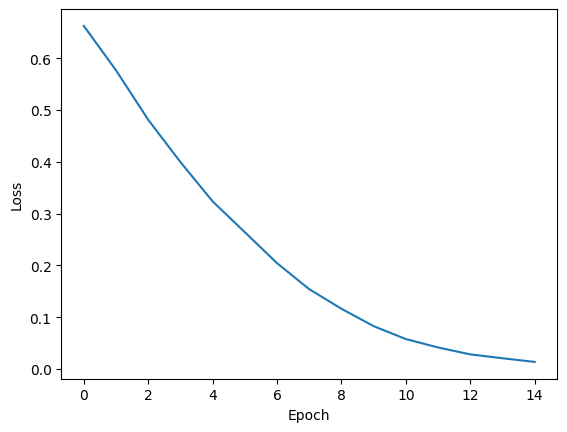


Model trained.

Testset Accuracy: 0.8017572762218561


In [ ]:
model = CNN(in_channels = 300, out_channels = 2, batch_size = 10)
model.train(train_iter = train_cnn_iter, val_iter = test_cnn_iter, num_epochs = 15, learning_rate = 1e-4)
model.test(test_cnn_iter)